In [ ]:
'''This notebook aims to predict the length of stay using various regression techniques (eventually), and
uses a training "scheme" where each model is trained on the year before, and evaluated on the preceding year.
This is the first of the two methods of training I'm currently considering.'''

import os
import datetime
import inspect
from typing import Dict, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import scatterplotmatrix
from sklearn.model_selection import (
    train_test_split, learning_curve, GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
)
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor
)
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    LogisticRegression, LinearRegression, RANSACRegressor, 
    Lasso, Ridge, ElasticNet
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, precision_recall_curve, 
    f1_score, mean_squared_error, mean_absolute_error, r2_score,
    root_mean_squared_log_error
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from utils import (
    describe_dataframe, get_cont_enrolled, train_eval, 
    piped_traineval, df_train_test, graph_results, reg_train_eval
)

In [2]:
main = pd.read_csv("../data/combo_data.csv")
main

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,YR,LOS,DRG,PRNCPAL_DGNS_CD,PTNT_DSCHRG_STUS_CD,CLM_IP_ADMSN_TYPE_CD,...,NUM_DIAG,ICD_Description,DRG_TITLE,STATE_CODE,COUNTY_CD,SEX_IDENT_CD,BENE_RACE_CD,ESRD_IND,Age,TOT_RX_CST_AMT
0,-10000010254618,-10000930037831,2015-03-25,2015-03-25,2015,0,551,S134XX,1,1,...,9,Sprain of ligaments of cervical spine,MEDICAL BACK PROBLEMS WITH MCC,1,1500,1,1,0,16,275.19
1,-10000010254653,-10000930038030,2015-09-24,2015-09-24,2015,0,951,Z3480,1,1,...,4,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1400,2,1,0,33,0.00
2,-10000010254653,-10000930038031,2017-05-09,2017-05-10,2017,1,923,T7432X,1,3,...,3,"Child psychological abuse, confirmed","OTHER INJURY, POISONING AND TOXIC EFFECT DIAGN...",1,1400,2,1,0,35,0.00
3,-10000010254656,-10000930038162,2017-01-14,2017-01-14,2017,0,564,S8290X,1,1,...,4,Unspecified fracture of unspecified lower leg,OTHER MUSCULOSKELETAL SYSTEM AND CONNECTIVE TI...,1,1360,2,1,0,18,302.04
4,-10000010254656,-10000930038163,2018-03-17,2018-03-17,2018,0,951,Z3480,1,1,...,6,Encounter for supervision of other normal pre...,OTHER FACTORS INFLUENCING HEALTH STATUS,1,1360,2,1,0,19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20862,-10000010288008,-10000931485965,2020-01-08,2020-01-14,2020,6,0,T50901A,1,3,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20863,-10000010288008,-10000931485967,2020-10-23,2020-10-23,2020,0,0,T50901A,1,1,...,12,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,75,0.00
20864,-10000010288008,-10000931485969,2021-08-22,2021-08-23,2021,1,0,T50901A,1,1,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00
20865,-10000010288008,-10000931485971,2021-09-13,2021-09-16,2021,3,0,T50901A,1,2,...,13,"Poisoning by unspecified drugs, medicaments an...",NaN,5,5430,1,5,0,76,0.00


In [3]:
describe_dataframe(main)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,BENE_ID,int64,20867,0,5699,"[-10000010254618, -10000010254653, -1000001025...",-10000010288010,-10000010254618,-10000010270649.408203
1,CLM_ID,int64,20867,0,20867,"[-10000930037831, -10000930038030, -1000093003...",-10000931486024,-10000930037831,-10000930747721.667969
2,CLM_FROM_DT,object,20867,0,2914,"[2015-03-25, 2015-09-24, 2017-05-09, 2017-01-1...",None,None,None
3,CLM_THRU_DT,object,20867,0,2910,"[2015-03-25, 2015-09-24, 2017-05-10, 2017-01-1...",None,None,None
4,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]",2015,2023,2019.100014
5,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]",0,104,1.054919
6,DRG,int64,20867,0,168,"[551, 951, 923, 564, 101]",0,976,662.292088
7,PRNCPAL_DGNS_CD,object,20867,0,190,"[S134XX, Z3480, T7432X, S8290X, Z3400]",None,None,None
8,PTNT_DSCHRG_STUS_CD,int64,20867,0,1,[1],1,1,1.0
9,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]",1,3,1.399195


In [4]:
#
select_cols = ["LOS" ,
               "YR",  
               "PRNCPAL_DGNS_CD", 
               "CLM_IP_ADMSN_TYPE_CD", 
               "ER_flag", 
               "STATE_CODE", 
               "COUNTY_CD", 
               "BENE_RACE_CD", 
               "ESRD_IND",
               "Age", 
               "TOT_RX_CST_AMT", 
               "NUM_DIAG",
               "SEX_IDENT_CD"]

In [ ]:
# Create a working dataframe with the selected columns so that original dataframe is not modified and can 
# be used to create other new dataframes if necessary
main.columns
workingdf = main[select_cols]

severe_codes = workingdf.loc[workingdf["LOS"] > 10, "PRNCPAL_DGNS_CD"].unique()
workingdf = workingdf.assign(SEV_FLAG=np.where(workingdf["PRNCPAL_DGNS_CD"].isin(severe_codes), 1, 0))
#Have to use severity flag (which could be determined in many ways) instead of PRCNPAL_DGNS_CD because PRNCP can't be used with regression
workingdf = workingdf.assign(ESRD_IND = workingdf["ESRD_IND"].map({"Y": 1, "0" : 0}))

workingdf = workingdf.drop(columns=["PRNCPAL_DGNS_CD"])

describe_dataframe(workingdf)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,20867,0,45,"[0, 1, 10, 11, 2]",0.0,104.00,1.054919
1,YR,int64,20867,0,9,"[2015, 2017, 2018, 2022, 2021]",2015.0,2023.00,2019.100014
2,CLM_IP_ADMSN_TYPE_CD,int64,20867,0,3,"[1, 3, 2]",1.0,3.00,1.399195
3,ER_flag,int64,20867,0,2,"[0, 1]",0.0,1.00,0.048498
4,STATE_CODE,int64,20867,0,51,"[1, 2, 3, 4, 6]",1.0,53.00,24.974553
5,COUNTY_CD,int64,20867,0,1350,"[1500, 1400, 1360, 1440, 1120]",1010.0,53220.00,25327.166339
6,BENE_RACE_CD,int64,20867,0,6,"[1, 4, 2, 5, 3]",1.0,6.00,2.049456
7,ESRD_IND,int64,20867,0,2,"[0, 1]",0.0,1.00,0.163943
8,Age,int64,20867,0,112,"[16, 33, 35, 18, 19]",0.0,111.00,66.288015
9,TOT_RX_CST_AMT,float64,20867,0,7231,"[275.19, 0.0, 302.04, 444.23, 408.33]",0.0,197011.98,11439.025583


In [7]:
#Need to divide up the data into training and testing sets by year
wdf_2016 = workingdf[workingdf["YR"] == 2016]
wdf_2017 = workingdf[workingdf["YR"] == 2017]

#one hot encode state, race, admission type
ohe = OneHotEncoder(sparse_output=False)

ohe.fit(wdf_2016[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']])
ohe_df_2016 = pd.DataFrame(data = ohe.transform(wdf_2016[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']]), 
             columns=ohe.get_feature_names_out(wdf_2016[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']].columns))

ohe.fit(wdf_2017[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']])
ohe_df_2017 = pd.DataFrame(data = ohe.transform(wdf_2017[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']]), 
             columns=ohe.get_feature_names_out(wdf_2017[['CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD']].columns))

#drop year, county code
wdf_2016 = wdf_2016.drop(columns=["YR", "COUNTY_CD", 'CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD'])
wdf_2017 = wdf_2017.drop(columns=["YR", "COUNTY_CD", 'CLM_IP_ADMSN_TYPE_CD', 'STATE_CODE', 'BENE_RACE_CD'])

wdf_2016 = pd.concat([wdf_2016.reset_index(drop=True), ohe_df_2016.reset_index(drop=True)], axis=1)
wdf_2017 = pd.concat([wdf_2017.reset_index(drop=True), ohe_df_2017.reset_index(drop=True)], axis=1)

In [8]:
describe_dataframe(wdf_2017)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,LOS,int64,2241,0,29,"[1, 0, 2, 5, 20]",0.0,37.00,0.895582
1,ER_flag,int64,2241,0,2,"[0, 1]",0.0,1.00,0.057564
2,ESRD_IND,int64,2241,0,2,"[0, 1]",0.0,1.00,0.144578
3,Age,int64,2241,0,105,"[35, 18, 53, 64, 73]",0.0,105.00,63.506024
4,TOT_RX_CST_AMT,float64,2241,0,821,"[0.0, 302.04, 2.2, 5133.22, 8352.81]",0.0,176744.63,11007.332838
...,...,...,...,...,...,...,...,...,...
63,BENE_RACE_CD_2,float64,2241,0,2,"[0.0, 1.0]",0.0,1.00,0.114235
64,BENE_RACE_CD_3,float64,2241,0,2,"[0.0, 1.0]",0.0,1.00,0.020973
65,BENE_RACE_CD_4,float64,2241,0,2,"[0.0, 1.0]",0.0,1.00,0.037037
66,BENE_RACE_CD_5,float64,2241,0,2,"[0.0, 1.0]",0.0,1.00,0.199911


In [ ]:
# Divide the data into training and testing sets
X_train_2016, X_test_2016, y_train_2016, y_test_2016 = df_train_test(wdf_2016, "LOS", 0.2)

X_train_2017, X_test_2017, y_train_2017, y_test_2017 = df_train_test(wdf_2017, "LOS", 0.2)

In [10]:
describe_dataframe(X_train_2017)

,column_name,dtype,non_null_count,null_count,unique_count,sample_values,min,max,mean
0,ER_flag,int64,1792,0,2,"[0, 1]",0.0,1.00,0.058036
1,ESRD_IND,int64,1792,0,2,"[0, 1]",0.0,1.00,0.146205
2,Age,int64,1792,0,105,"[101, 74, 12, 61, 79]",0.0,105.00,63.535156
3,TOT_RX_CST_AMT,float64,1792,0,685,"[42780.98, 0.0, 6761.08, 4.0200000000000005, 1...",0.0,176744.63,11129.406055
4,NUM_DIAG,int64,1792,0,47,"[37, 30, 4, 21, 16]",1.0,54.00,21.170201
...,...,...,...,...,...,...,...,...,...
62,BENE_RACE_CD_2,float64,1792,0,2,"[0.0, 1.0]",0.0,1.00,0.113281
63,BENE_RACE_CD_3,float64,1792,0,2,"[0.0, 1.0]",0.0,1.00,0.022321
64,BENE_RACE_CD_4,float64,1792,0,2,"[0.0, 1.0]",0.0,1.00,0.033482
65,BENE_RACE_CD_5,float64,1792,0,2,"[0.0, 1.0]",0.0,1.00,0.193080


In [ ]:
# Create dictionaries for metrics and to store predictions for the calculations of metrics
reg_mod_metrics = {"Test":{},
                   "Train":{}}

predictions = {}

#Always need to test on a future year because the training data has already been observed (and so testing on it
# gives you no new information, and is not a useful application).

reg_train_eval(LinearRegression(),
               None,
               X_train_2016,
               y_train_2016,
               X_test_2017,
               y_test_2017,
               reg_mod_metrics,
               predictions,
               year = "2016train-2017test")

# Above returns the R^2 score directly, other metrics stored in reg_mod_metrics dictionary

0.30129147112574084

In [12]:
reg_mod_metrics

{'Test': {'LinearRegression - NoneType - 2016train-2017test': {'RMSLE': 0.46742167078115165,
   'R2': 0.30129147112574084,
   'MAE': 0.9067930411502675,
   'MSE': 5.296115062132563}},
 'Train': {'LinearRegression - NoneType - 2016train-2017test': {'RMSLE': 0.4205892460134721,
   'R2': 0.38159804475352666,
   'MAE': 0.8331782641647552,
   'MSE': 4.626091008258963}}}

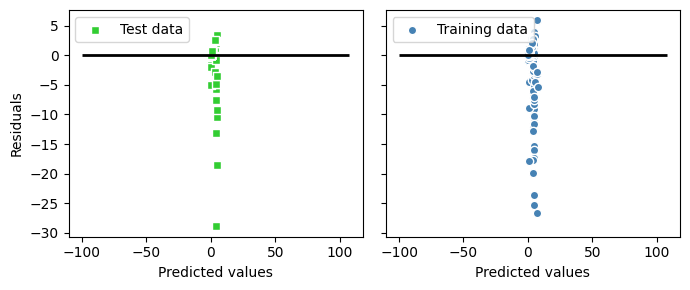

In [13]:
# Graph results

graph_results(predictions["LinearRegression - NoneType - 2016train-2017test"]["y_predict_train"], 
              predictions["LinearRegression - NoneType - 2016train-2017test"]["y_predict"], 
              y_train_2016, 
              y_test_2017)